# Context

## My Content : Books recommandation mobile app

This is a start-up who's goal is to encourage people to read by recommending relevant content to users.

In this project, we create an app that recommend relevant articles to users based on their implicit preferences, their profiles and the articles content. This is known as a Recommender System and is a very common challenge in any content-based website (blog, news, audio/video, ...) or service (social network, marketplace, streaming platform, dating platform, ....).

We compare different models (Content-Based Filtering, Collaborative Filtering) on the Globo.com dataset. Then, we will integrate one model in an app that will be able to recommend relevant articles to users. Finally, we will use Azure Functions to store the recommendations in Azure CosmosDB and to make the recommendations available to the users.

# Import libraries

In [435]:
## Import libraries
import os

from datetime import datetime
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from utils import *
import seaborn as sns

from surprise import Reader, Dataset, dump
from surprise.model_selection import train_test_split, cross_validate, GridSearchCV
from surprise import SVD, SVDpp, NMF, CoClustering, accuracy
from sklearn.metrics.pairwise import linear_kernel,cosine_similarity

import progressbar

# Data

Let's download the data from the Globo.com dataset and look at what it contains.

The dataset is composed of the following files :

 - data/clicks/ : contains 385 CSV files
     - data/clicks/clicks_hour_*.csv : contains one hour of clicks on the website
 - articles_embeddings.pickle : pickle file containing the embeddings of the articles
 - articles_metadata.csv : CSV file containing the metadata of the articles
 - clicks_sample.csv

## Articles metadata

In [2]:
articles_metadata = pd.read_csv(
    Path('data/', "articles_metadata.csv"),
    parse_dates=["created_at_ts"],
    date_parser=lambda x: datetime.fromtimestamp(int(x) / 1000),
    dtype={
        "article_id": "int",
        "category_id": "int",
        "publisher_id": "int",
        "words_count": "int",
    },
)

articles_metadata = articles_metadata.astype({"created_at_ts": "datetime64[ns]"})

In [3]:
print_columns(articles_metadata)

1:article_id
2:category_id
3:created_at_ts
4:publisher_id
5:words_count


In [4]:
articles_metadata.shape

(364047, 5)

In [5]:
articles_metadata.head()

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,2017-12-13 06:53:39,0,168
1,1,1,2014-07-14 14:45:36,0,189
2,2,1,2014-08-22 02:35:06,0,250
3,3,1,2014-08-19 19:11:53,0,230
4,4,1,2014-08-03 15:06:11,0,162


In [6]:
articles_metadata.describe(include="all", datetime_is_numeric=True)

,article_id,category_id,created_at_ts,publisher_id,words_count
count,364047.000000,364047.000000,364047,364047.0,364047.000000
mean,182023.000000,283.108239,2016-09-17 01:25:54.949498624,0.0,190.897727
min,0.000000,0.000000,2006-09-27 13:14:35,0.0,0.000000
25%,91011.500000,199.000000,2015-10-15 18:00:43.500000,0.0,159.000000
50%,182023.000000,301.000000,2017-03-13 17:27:29,0.0,186.000000
75%,273034.500000,399.000000,2017-11-05 15:09:11,0.0,218.000000
max,364046.000000,460.000000,2018-03-13 13:12:30,0.0,6690.000000
std,105091.461061,136.723470,NaN,0.0,59.502766


In [7]:
# afficher les valeurs unique pour chaque variable
articles_metadata.nunique()

article_id       364047
category_id         461
created_at_ts    359552
publisher_id          1
words_count         866
dtype: int64

- article_id : unique id for the article
- category_id : the category of the article, there is 461 category.
- created_at_ts : timestamp when the article as been created. You should remove the 3 last numbers. Oldest article : 2006/09/27 11:14:35. Newest : 2018/3/13 12:12:30.
- publisher_id : seems empty. only 0
- words_count : how many words in the article. From 0 (seems a bug) to 6690. Distribution is available in few cells.

In [8]:
a = articles_metadata["words_count"].min()
b = articles_metadata["words_count"].max()
print('minimum number of words per article = {0} and maximum number of words per article = {1}'.format(a,b))

minimum number of words per article = 0 and maximum number of words per article = 6690


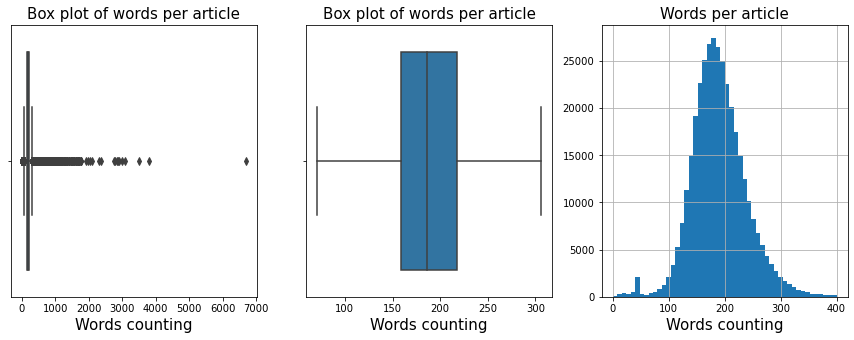

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(x=articles_metadata["words_count"], ax = axes[0])
axes[0].set_title('Box plot of words per article', fontsize=15);
axes[0].set_xlabel('Words counting', fontsize=15);

sns.boxplot(x=articles_metadata["words_count"], showfliers=False, ax = axes[1])
axes[1].set_title('Box plot of words per article', fontsize=15);
axes[1].set_xlabel('Words counting', fontsize=15);

articles_metadata.words_count.hist(bins=50, range=(0,400), ax = axes[2])
axes[2].set_title('Words per article', fontsize=15);
axes[2].set_xlabel('Words counting', fontsize=15);

***Missing values in dataset***

In [10]:
missing_values_table(articles_metadata)

Your selected dataframe has 5 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


***Are there any empty articles in dataset?***

In [11]:
print(f'Empty article(s) : {articles_metadata[articles_metadata["words_count"] == 0].count()[0]}')

Empty article(s) : 35


***When the articles was created?***

In [12]:
articles_metadata['year'] = articles_metadata['created_at_ts'].dt.year
articles_metadata['month'] = articles_metadata['created_at_ts'].dt.month

In [13]:
articles_metadata.head()

,article_id,category_id,created_at_ts,publisher_id,words_count,year,month
0,0,0,2017-12-13 06:53:39,0,168,2017,12
1,1,1,2014-07-14 14:45:36,0,189,2014,7
2,2,1,2014-08-22 02:35:06,0,250,2014,8
3,3,1,2014-08-19 19:11:53,0,230,2014,8
4,4,1,2014-08-03 15:06:11,0,162,2014,8


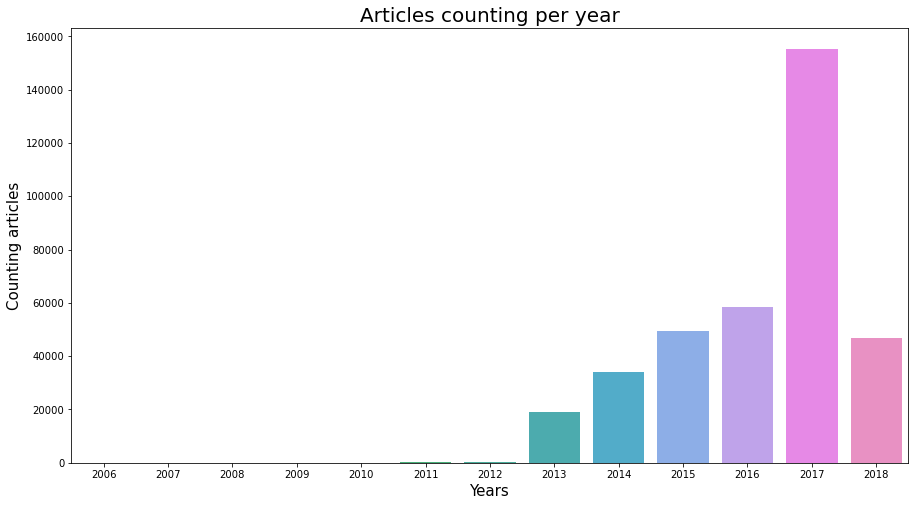

In [14]:
x = articles_metadata.groupby('year')['article_id'].count()
x = x.reset_index()
x.columns = ['Year', 'frequency']
x = x.sort_values(by='frequency')
plt.figure(figsize=(15,8))
sns.barplot(x = 'Year', y = 'frequency', data = x)
plt.title('Articles counting per year', fontsize=20);
plt.xlabel('Years', fontsize=15);
plt.ylabel('Counting articles', fontsize=15);
plt.show();

Observe that the highest number of articles are created in 2017. However the database starts with some articles from 2006 and ends in 2018.

***How much articles per category?***

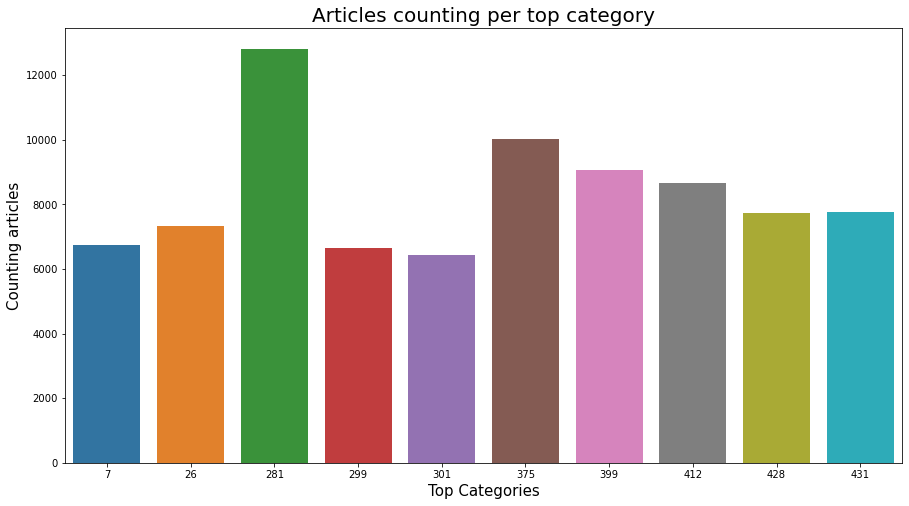

In [17]:
x = articles_metadata.groupby('category_id')['article_id'].count()
x = x.reset_index()
x.columns = ['Category', 'frequency']
x = x.sort_values(by='frequency', ascending=False)

plt.figure(figsize=(15,8))
sns.barplot(x = 'Category', y = 'frequency', data = x.head(10))
plt.title('Articles counting per top category', fontsize=20);
plt.xlabel('Top Categories', fontsize=15);
plt.ylabel('Counting articles', fontsize=15);
plt.show();

The most read category by users are the category with the id = 281.

## Clicks dataset

In [15]:
clicks_samp_df = pd.read_csv('data/clicks_sample.csv')

In [16]:
clicks_samp_df.head(5)

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


In [17]:
clicks_samp_df.nunique()

user_id                 707
session_id              707
session_start           619
session_size             11
click_article_id        323
click_timestamp        1883
click_environment         3
click_deviceGroup         3
click_os                  6
click_country             7
click_region             26
click_referrer_type       6
dtype: int64

In [18]:
missing_values_table(clicks_samp_df)

Your selected dataframe has 12 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


- user_id : user ID
- session_id : Session ID
- session_start : Start of the session (timestamp)
- session_size : number of click/session
- words_count : Total word contain in the article
- click_article_id : article ID user clicked
- click_timestamp : When user clicked (timestamp)
- click_environment : user env when click
- click_deviceGroup : user device
- click_os : user OS
- click_country : localisation (country) when user clicked
- click_region : localisation (region) when user clicked
- click_referrer_type : ?

In [19]:
%%time

CLICK_FILES_PATH = "data/clicks/"

#Get all .csv contain in clicks folder
click_files = [CLICK_FILES_PATH + x for x in os.listdir(CLICK_FILES_PATH)];

#Sort all files PATH contain in list.
click_files.sort()

#Check if all files are present.
print("Total PATH contain in list : ", len(click_files))

Total PATH contain in list :  385
CPU times: user 1.26 ms, sys: 2.58 ms, total: 3.84 ms
Wall time: 3.9 ms


In [20]:
click_files[:3]

['data/clicks/clicks_hour_000.csv',
 'data/clicks/clicks_hour_001.csv',
 'data/clicks/clicks_hour_002.csv']

We gether only the information about the user and the article was clicked by the specific user.

In [133]:
%%time
list_click_file_to_df = [pd.read_csv(x, index_col=None, header=0) for x in click_files];

#Remove unused columns
list_click_file_to_df_cleaned = [x.drop(columns = ['session_id',
                                                   'session_start',
                                                   'session_size',
                                                   'click_timestamp',
                                                   'click_environment',
                                                   'click_deviceGroup',
                                                   'click_os',
                                                   'click_country',
                                                   'click_region',
                                                   'click_referrer_type']) for x in list_click_file_to_df]

all_clicks_df = pd.concat(list_click_file_to_df_cleaned, axis=0, ignore_index=True)

#all_clicks_df = all_clicks_df.astype({"click_timestamp": "datetime64[ns]"})

print(f"DataFrame shape : {all_clicks_df.shape}")

DataFrame shape : (2988181, 2)
CPU times: user 1.23 s, sys: 163 ms, total: 1.39 s
Wall time: 1.55 s


In [134]:
all_clicks_df.head()

,user_id,click_article_id
0,0,157541
1,0,68866
2,1,235840
3,1,96663
4,2,119592


In [135]:
all_clicks_df[all_clicks_df.user_id == 5890]

,user_id,click_article_id
16162,5890,59704
16163,5890,59431
16164,5890,68866
16165,5890,195106
16166,5890,353724
...,...,...
2925686,5890,58258
2925687,5890,218355
2925688,5890,144840
2925846,5890,202320


In [136]:
all_clicks_df.describe()

,user_id,click_article_id
count,2988181,2988181
unique,322897,46033
top,5890,160974
freq,1232,37213


We can from this dataset that there are 322897 users that clicked on 46033 articles. The top user is the user with the id 5890. He clicked 1232 times. The top article that was clicked is the 160974 article with the frequency of 37213 times.

## Articles Embeddings

Finally this is the data that describes the content for each article. We will use it for our contet based recomandation.

In [25]:
## Load and describe Articles Embeddings data

articles_embeddings = pd.read_pickle(Path('data/', "articles_embeddings.pickle"))

In [26]:
articles_embeddings

array([[-0.16118301, -0.95723313, -0.13794445, ..., -0.231686  ,
         0.5974159 ,  0.40962312],
       [-0.52321565, -0.974058  ,  0.73860806, ...,  0.18282819,
         0.39708954, -0.83436364],
       [-0.61961854, -0.9729604 , -0.20736018, ..., -0.44758022,
         0.8059317 , -0.28528407],
       ...,
       [-0.25139043, -0.9762427 ,  0.58609664, ..., -0.14372464,
         0.06809307, -0.7050104 ],
       [ 0.22434181, -0.92328775, -0.38174152, ...,  0.6871319 ,
        -0.5315117 ,  0.01072566],
       [-0.25713393, -0.9946313 ,  0.9837918 , ...,  0.98387307,
        -0.8381829 , -0.1792827 ]], dtype=float32)

In [31]:
articles = pd.DataFrame(
    articles_embeddings,
    columns=["embedding_" + str(i) for i in range(articles_embeddings.shape[1])],
)

In [32]:
articles.head()

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_240,embedding_241,embedding_242,embedding_243,embedding_244,embedding_245,embedding_246,embedding_247,embedding_248,embedding_249
0,-0.161183,-0.957233,-0.137944,0.050855,0.830055,0.901365,-0.335148,-0.559561,-0.500603,0.165183,...,0.321248,0.313999,0.636412,0.169179,0.540524,-0.813182,0.286870,-0.231686,0.597416,0.409623
1,-0.523216,-0.974058,0.738608,0.155234,0.626294,0.485297,-0.715657,-0.897996,-0.359747,0.398246,...,-0.487843,0.823124,0.412688,-0.338654,0.320787,0.588643,-0.594137,0.182828,0.397090,-0.834364
2,-0.619619,-0.972960,-0.207360,-0.128861,0.044748,-0.387535,-0.730477,-0.066126,-0.754899,-0.242004,...,0.454756,0.473184,0.377866,-0.863887,-0.383365,0.137721,-0.810877,-0.447580,0.805932,-0.285284
3,-0.740843,-0.975749,0.391698,0.641738,-0.268645,0.191745,-0.825593,-0.710591,-0.040099,-0.110514,...,0.271535,0.036040,0.480029,-0.763173,0.022627,0.565165,-0.910286,-0.537838,0.243541,-0.885329
4,-0.279052,-0.972315,0.685374,0.113056,0.238315,0.271913,-0.568816,0.341194,-0.600554,-0.125644,...,0.238286,0.809268,0.427521,-0.615932,-0.503697,0.614450,-0.917760,-0.424061,0.185484,-0.580292


In [33]:
articles.shape

(364047, 250)

In [34]:
articles.describe(include="all", datetime_is_numeric=True)

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_240,embedding_241,embedding_242,embedding_243,embedding_244,embedding_245,embedding_246,embedding_247,embedding_248,embedding_249
count,364047.000000,364047.000000,364047.000000,364047.000000,364047.000000,364047.000000,364047.000000,364047.000000,364047.000000,364047.000000,...,364047.000000,364047.000000,364047.000000,364047.000000,364047.000000,364047.000000,364047.000000,364047.000000,364047.000000,364047.000000
mean,-0.238647,-0.963000,0.118547,-0.279296,-0.068579,0.045944,-0.168321,-0.216566,-0.006809,-0.019156,...,-0.133286,-0.081914,-0.060347,0.023003,0.076946,0.084603,0.062819,0.099768,0.155917,-0.041092
std,0.451477,0.022650,0.495033,0.505040,0.506702,0.483264,0.514170,0.456190,0.519020,0.448762,...,0.490577,0.449941,0.489480,0.507167,0.426127,0.467973,0.462653,0.499622,0.454330,0.458802
min,-0.991183,-0.996455,-0.968431,-0.994966,-0.994489,-0.985974,-0.995090,-0.995926,-0.991316,-0.990957,...,-0.990412,-0.989408,-0.990432,-0.993626,-0.989042,-0.996902,-0.992921,-0.984733,-0.976071,-0.988213
25%,-0.620072,-0.974056,-0.289953,-0.718816,-0.503425,-0.354579,-0.610391,-0.604471,-0.446108,-0.377319,...,-0.547684,-0.445079,-0.479989,-0.404508,-0.248653,-0.267072,-0.306548,-0.313598,-0.201402,-0.420694
50%,-0.302581,-0.967605,0.124339,-0.391535,-0.093734,0.062636,-0.259313,-0.257692,-0.025777,0.000807,...,-0.175781,-0.094113,-0.078034,0.000726,0.105649,0.133525,0.083315,0.128757,0.188355,-0.015232
75%,0.098015,-0.959061,0.545112,0.108320,0.345024,0.446979,0.244957,0.138783,0.432606,0.343574,...,0.250641,0.270006,0.341105,0.459386,0.417347,0.461466,0.441831,0.531453,0.538111,0.334226
max,0.983694,-0.514728,0.998341,0.978092,0.996798,0.996343,0.990139,0.963327,0.992945,0.978029,...,0.996401,0.981789,0.991332,0.995299,0.978823,0.989324,0.991445,0.997583,0.990507,0.968462


### Normalization

In [35]:
std_scale = StandardScaler().fit(articles) #preprocessing.MinMaxScaler, StandardScaler RobustScaler
articles_norm = pd.DataFrame(std_scale.transform(articles), columns=articles.columns)

### Dimension reduction

In [36]:
pca_features_ratio = {}
explained_by_pca = 0.95
is_not_selected=True

pca = PCA(random_state=10)
pca.fit(articles_norm)
for k in range(articles_norm.shape[1]):
    s = np.cumsum(pca.explained_variance_ratio_)[k]
    pca_features_ratio[k] = s
    if ((s>=explained_by_pca) & is_not_selected):
        n_comp = k
        is_not_selected = False

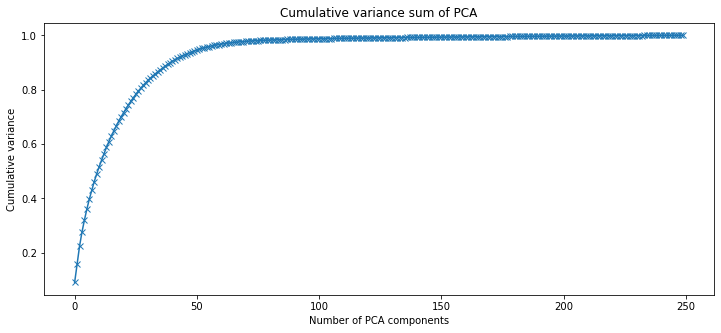

In [37]:
plt.figure(figsize=(12,5));
plt.title('Cumulative variance sum of PCA');
plt.xlabel('Number of PCA components');
plt.ylabel('Cumulative variance');
plt.plot(list(range(articles_norm.shape[1])),
np.cumsum(pca.explained_variance_ratio_), '-x');

In [38]:
np.cumsum(pca.explained_variance_ratio_)[n_comp]

0.9517011130781636

In [39]:
n_comp

52

In [40]:
# Calcul des composantes principales
colonnes_pca = articles_norm.columns
    
pca = PCA(n_components=n_comp, random_state=10)
pca.fit(articles_norm)

X_projected = pca.fit_transform(articles_norm)


X_projected = pd.DataFrame(X_projected, index = articles_norm.index, columns = ['F{0}'.format(i) for i in range(n_comp)])

X_projected

,F0,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F42,F43,F44,F45,F46,F47,F48,F49,F50,F51
0,-1.825835,5.492387,1.696645,3.813572,-1.406175,0.245708,0.433323,0.463560,-0.843627,-1.483162,...,-2.243141,-0.043467,-0.819398,-0.033513,0.425652,-0.548755,-0.266953,0.279686,0.028080,-1.612632
1,-5.360800,-4.153498,-2.383132,3.405946,0.415792,3.745716,2.427250,-1.257968,1.976774,-2.968710,...,0.493704,1.270145,-0.680690,-0.374263,1.369758,1.343116,-0.790313,-0.377357,-0.572691,-1.137887
2,-3.566296,0.196346,-5.930864,-0.969486,-0.200690,4.784123,-1.773982,-2.038435,-2.636897,-2.779618,...,0.749348,1.990119,0.225735,-0.058376,1.202185,-0.146867,0.364746,-0.862416,0.190227,-0.002803
3,-1.140845,-7.202567,-5.815835,1.369689,-2.150083,-1.650238,1.014849,-2.211862,1.902957,-4.098051,...,0.781717,0.549316,-0.778600,-0.013438,0.982137,-0.503001,-0.591588,-0.426197,1.475111,-0.734342
4,-1.137118,-2.605412,-2.899077,0.323826,-2.815987,5.854429,0.396662,0.386378,-0.997668,-2.191393,...,1.820595,0.460761,-0.794159,-2.116440,1.380177,1.177155,-0.771651,0.656011,0.056401,-0.259069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364042,1.901259,-7.378514,8.403327,-1.005399,1.738697,-1.755885,1.745632,1.135498,0.902941,-1.933206,...,0.836364,-1.972440,0.571997,-0.714813,0.651352,-0.025250,-0.596499,0.585364,-0.775066,-0.115959
364043,0.976340,-1.572773,6.443746,3.159405,14.464374,3.175482,1.287498,3.976866,0.024869,-1.578855,...,0.666858,0.577114,2.746678,-2.098413,-0.343546,-0.295341,-3.474389,-0.924266,-0.780766,-1.280870
364044,1.205793,-9.494565,3.041075,2.910936,2.307938,0.475877,-2.256176,0.401628,3.293910,4.190050,...,1.445938,-0.827069,-0.915309,-0.051054,-0.373695,0.457426,0.310209,-1.460327,0.897294,0.837937
364045,11.508966,-1.546849,-0.131350,-0.648061,-2.660388,-2.058005,-2.533999,1.115753,1.056864,-2.310452,...,0.513706,-0.458607,-0.599375,0.288746,-0.612194,1.207650,0.015135,-1.099968,-0.635543,0.415464


In [41]:
#articles["words_count"] = articles_metadata["words_count"]
X_projected["category_id"] = articles_metadata["category_id"]
X_projected["article_id"] = articles_metadata["article_id"]

### Visualization with PCA

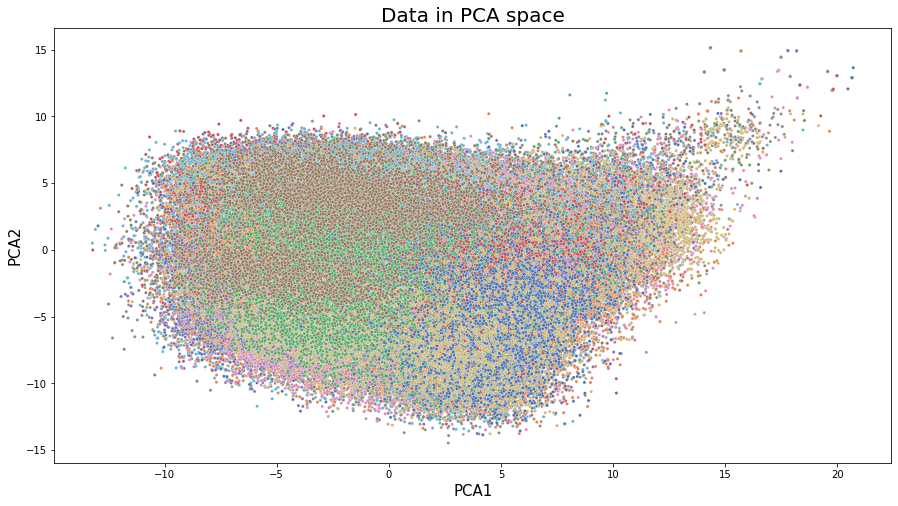

In [44]:
plt.figure(figsize=(15,8));
sns.scatterplot(data=X_projected, x="F0", y="F1", legend=False,  hue='category_id',s=10, palette="deep");
plt.title('Data in PCA space', fontsize=20);
plt.xlabel('PCA1', fontsize=15);
plt.ylabel('PCA2', fontsize=15);
plt.show();

# Recommendation Systems
The goal of Recommender Systems is to suggest relevant content to users. In this work we will recomand 5 articles for a user using some techniques. First we explore the 
 - Content-Based Filtering : based on content features and the user's content preferences. 
This will be treated as a baseline. First, we regard the embedding matrix and the distance between the articles content vectors. We will recomend to the user the top 5 articles that are closest to the articles he read.

Next we do the content based recomandation system based on the video [link](https://www.youtube.com/watch?v=YMZmLx-AUvY) that explains breafly the idea of this types of systems. Here we are going to recreate a matrix for the article and the user preferenced only based on previous clicks.

Next we explore the 
 - Collaborative Filtering : based on the user's content preferences and the user's profiles.
 
There exist also the 
 - Hybrid recommender systems : a combination of the two previous ones,
but this one is not explored in this work

## Content based using embedding matrix

In [110]:
def get_articles_user_clicked(clicks, user_id):
    usr_click = X_projected.query("article_id in @all_article_ids")
    usr_not_click = X_projected.query("article_id not in @all_article_ids")
    
    return usr_click.drop(columns=['category_id', 'article_id']).to_numpy(), usr_click[['category_id', 'article_id']], usr_not_click.drop(columns=['category_id', 'article_id']).to_numpy(), usr_not_click[['category_id', 'article_id']]

In [453]:
all_clicks_df

,user_id,click_article_id
0,0,157541
1,0,68866
2,1,235840
3,1,96663
4,2,119592
...,...,...
2988176,10051,84911
2988177,322896,30760
2988178,322896,157507
2988179,123718,234481


In [111]:
embedding_articles_user_clicked, cat_art_usr_click,  embedding_articles, cat_art, = get_articles_user_clicked(all_clicks_df, user_id=0)

In [195]:
from operator import itemgetter

def find_top_n_indices(data, top=5):
    indexed = enumerate(data)
    
    sorted_data = sorted(indexed, 
                         key=itemgetter(1), 
                         reverse=True) 
    result = {} 
    
    for article, score in sorted_data[:top]:
        result[article] = score
    
    return result

In [196]:
def recommendFromArticle(article_emb, top=5):
    score = []
    for i in range(0, len(embedding_articles)):
        cos_sim = np.dot(article_emb, embedding_articles[i])/(np.linalg.norm(article_emb)*np.linalg.norm(embedding_articles[i]))
        score.append(cos_sim)
    
    _best_scores = find_top_n_indices(score, top)
            
    return _best_scores

### taking the mean of the articles user clicked

In [198]:
article_emb = np.mean(embedding_articles_user_qclicked, axis=0)
recommendFromArticle(article_emb, top=5)

{161127: 0.85556835,
 161783: 0.8521197,
 162229: 0.84923685,
 107633: 0.84131056,
 162224: 0.8385792}

### taking the random article the user clicked

In [201]:
art = random.randrange(len(embedding_articles_user_clicked))
article_emb = embedding_articles_user_clicked[art]
recommendFromArticle(article_emb, top=5)

{284631: 0.9164293,
 107672: 0.90671355,
 86383: 0.9063348,
 37089: 0.90347016,
 98305: 0.90260416}

## Colaborative filtering recomandation system 
Please see the following [link](https://medium.com/hacktive-devs/recommender-system-made-easy-with-scikit-surprise-569cbb689824) for more information in how to use the surprise package used for collaborative filtering.

### Data preparation

In [254]:
all_clicks_df.head()

,user_id,click_article_id
0,0,157541
1,0,68866
2,1,235840
3,1,96663
4,2,119592


In [255]:
all_clicks_df = all_clicks_df.astype({'user_id':'int',
                        'click_article_id':'int'})
all_clicks_df.dtypes

user_id             int64
click_article_id    int64
dtype: object

In [256]:
%%time
df = all_clicks_df.merge(articles_metadata, left_on='click_article_id', right_on='article_id')
df = df[['user_id', 'article_id', 'category_id']]
df.head()

CPU times: user 202 ms, sys: 147 ms, total: 349 ms
Wall time: 374 ms


,user_id,article_id,category_id
0,0,157541,281
1,20,157541,281
2,44,157541,281
3,45,157541,281
4,76,157541,281


In [257]:
df.dtypes

user_id        int64
article_id     int64
category_id    int64
dtype: object

In [258]:
user_activity = df.groupby('user_id').agg(
    user_total_click = ('user_id', 'count'),
)
user_activity.head()

,user_total_click
user_id,
0,8
1,12
2,4
3,17
4,7


In [260]:
# compute how many times the user clicked an article
data = df.groupby(['user_id', 'article_id']).size().to_frame().reset_index()
data.rename(columns = {0:'rate'}, inplace = True)

# compute the total number of clicks per user
user_activity = df.groupby('user_id').size().to_frame().reset_index()
user_activity.rename(columns = {0:'user_clicks'}, inplace = True)

# compute the rating
ratings = pd.merge(data, user_activity,
         how='left', on='user_id')
ratings['rating'] = ratings.rate / ratings.user_clicks
ratings = ratings[['user_id', 'article_id', 'rating']]
ratings

,user_id,article_id,rating
0,0,68866,0.125
1,0,87205,0.125
2,0,87224,0.125
3,0,96755,0.125
4,0,157541,0.125
...,...,...,...
2950705,322894,168401,0.500
2950706,322895,63746,0.500
2950707,322895,289197,0.500
2950708,322896,30760,0.500


In [449]:
%%time
# saving ratings to use in the application. This data contains the user and the article it clicked
# this one takes more then 100mb
ratings[['user_id', 'article_id']].to_pickle('results/ratings.pkl')

CPU times: user 9.31 ms, sys: 18.5 ms, total: 27.8 ms
Wall time: 26.8 ms


In [450]:
%%time
# saving ratings to use in the application. This data contains the user and the article it clicked
# this one takes 11mb
ratings[['user_id', 'article_id']].to_parquet('results/ratings.gzip', compression='gzip')
#d = pd.read_parquet('results/ratings.gzip')

CPU times: user 2.02 s, sys: 64.5 ms, total: 2.09 s
Wall time: 2.52 s


### Setting data for surprize

In [261]:
reader = Reader(rating_scale=(0,1))

In [262]:
data = Dataset.load_from_df(ratings, reader)

In [269]:
%%time
trainset, testset = train_test_split(data, test_size=0.2, random_state=0)
print('Test set lenght :', len(testset))
print('Train set lenght :', len(data.df) - len(testset))

Test set lenght : 590142
Train set lenght : 2360568
CPU times: user 4.12 s, sys: 51.5 ms, total: 4.17 s
Wall time: 4.17 s


### Computation the recomandation with surprise

We will use the RMSE accuracy to understand what model fits best our dataset.

In [273]:
%%time

ratings_sample = ratings.sample(frac=0.01, random_state=35)
data = Dataset.load_from_df(ratings_sample, reader)
print('the lenght of the data is : {0}'.format(len(data.df)))

param_grid = {
    "n_factors": [1, 5, 10, 20, 50, 100],  
    "n_epochs": [1, 10, 20, 50, 100],  
    "lr_all": [0.0001, 0.0005, 0.005, 0.01],  
    "reg_all": [0.0001, 0.002, 0.02, 0.05], 
}
grid = GridSearchCV(
    SVD,
    param_grid,
    measures=["rmse", "mae"],
    cv=3,
    refit=True,
    return_train_measures=True,
    n_jobs=-1,
    joblib_verbose=9,
)

grid.fit(data)

# best RMSE score
print(grid.best_score["rmse"])

# combination of parameters that gave the best RMSE score
print(grid.best_params["rmse"])

the lenght of the data is : 29507


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 108 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 222 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 318 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 372 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 492 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 558 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 628 tasks      | elapsed:  

0.1277667772773952
{'n_factors': 1, 'n_epochs': 100, 'lr_all': 0.01, 'reg_all': 0.05}
CPU times: user 24.7 s, sys: 1.25 s, total: 25.9 s
Wall time: 42.6 s


In [274]:
%%time

ratings_sample = ratings.sample(frac=0.1, random_state=35)
data = Dataset.load_from_df(ratings_sample, reader)
print('the lenght of the data is : {0}'.format(len(data.df)))

param_grid = {
    "n_factors": [1, 5, 10, 20, 50, 100],  
    "n_epochs": [1, 10, 20, 50, 100],  
    "lr_all": [0.0001, 0.0005, 0.005, 0.01],  
    "reg_all": [0.0001, 0.002, 0.02, 0.05], 
}
grid = GridSearchCV(
    SVD,
    param_grid,
    measures=["rmse", "mae"],
    cv=3,
    refit=True,
    return_train_measures=True,
    n_jobs=-1,
    joblib_verbose=9,
)

grid.fit(data)

# best RMSE score
print(grid.best_score["rmse"])

# combination of parameters that gave the best RMSE score
print(grid.best_params["rmse"])

the lenght of the data is : 295071


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 108 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 222 tasks      | elapsed:   57.4s
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 318 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 372 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 492 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 558 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 628 tasks      | elapsed:  

0.10607669931497972
{'n_factors': 1, 'n_epochs': 100, 'lr_all': 0.01, 'reg_all': 0.002}
CPU times: user 4min 17s, sys: 12.2 s, total: 4min 29s
Wall time: 7min 42s


In [270]:
cross_validate(SVD(), data, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.1751  0.1753  0.1751  0.1752  0.1754  0.1752  0.0001  
MAE (testset)     0.1476  0.1477  0.1474  0.1476  0.1478  0.1476  0.0001  
Fit time          15.17   14.42   15.33   15.06   14.54   14.90   0.36    
Test time         3.14    2.69    2.88    2.67    2.74    2.83    0.17    


{'test_rmse': array([0.17511612, 0.17534194, 0.17505062, 0.17518515, 0.17536949]),
 'test_mae': array([0.14761002, 0.14765742, 0.14743303, 0.14763011, 0.14777051]),
 'fit_time': (15.173121929168701,
  14.4151029586792,
  15.328258037567139,
  15.059014081954956,
  14.541679859161377),
 'test_time': (3.1434848308563232,
  2.6887078285217285,
  2.877692937850952,
  2.673661231994629,
  2.741534948348999)}

In [277]:
cross_validate(SVD(n_factors=1, n_epochs=100, lr_all=0.01, reg_all=0.002), data, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.1033  0.1039  0.1034  0.1027  0.1032  0.1033  0.0004  
MAE (testset)     0.0631  0.0637  0.0633  0.0628  0.0631  0.0632  0.0003  
Fit time          5.72    5.69    6.15    5.44    5.68    5.73    0.23    
Test time         0.15    0.15    0.15    0.15    0.16    0.15    0.00    


{'test_rmse': array([0.10334471, 0.10393578, 0.10340184, 0.10269715, 0.10317108]),
 'test_mae': array([0.06313047, 0.06370479, 0.06333051, 0.06283924, 0.06313905]),
 'fit_time': (5.718658924102783,
  5.685728073120117,
  6.147464990615845,
  5.442944049835205,
  5.678958177566528),
 'test_time': (0.14869284629821777,
  0.15280890464782715,
  0.1522519588470459,
  0.1492311954498291,
  0.16013717651367188)}

In [279]:
%%time
algo = SVD(n_factors=1, n_epochs=100, lr_all=0.01, reg_all=0.002)
algo.fit(trainset)
predictions = algo.test(testset)
print('Number of predictions in Test set :', len(predictions))
accuracy.rmse(predictions)

Number of predictions in Test set : 590142
RMSE: 0.0952
CPU times: user 42.5 s, sys: 205 ms, total: 42.7 s
Wall time: 42.7 s


0.0952371782771097

In [444]:
%%time
def get_rating_user(ratings, user_id):
    ratings_user = ratings[ratings.user_id!=user_id]
    ratings_user = ratings_user.drop_duplicates(subset=['article_id'])
    ratings_user.user_id = user_id
    ratings_user = ratings_user.reset_index(drop=True)
    return ratings_user

def pred(usr, art):
    return algo.predict(usr, art).est

user_id = 0
ratings_user = get_rating_user(ratings, user_id)

rtigs = pd.Series(map(pred, ratings_user.user_id, ratings_user.article_id)) 

ratings_user = ratings_user.assign(rating = rtigs)

recomandations = ratings_user.sort_values('rating', ascending=False).head(5)[['article_id', 'rating']]

CPU times: user 178 ms, sys: 62.4 ms, total: 241 ms
Wall time: 254 ms


In [445]:
recomandations.set_index('article_id')['rating'].to_dict()

{25058: 0.2622345553425753,
 161491: 0.2595398812789564,
 73431: 0.2564006086100485,
 289003: 0.24398109533069326,
 74501: 0.24182039007693554}

### Saving/loading model

In [436]:
dump.dump('results/surprise_model.pkl', predictions=None, algo=algo, verbose=0)

In [439]:
del algo

In [442]:
_, algo = dump.load('results/surprise_model.pkl')

In [443]:
algo